## Load documents with IDs

In [1]:
import requests
 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load grount truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [4]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [5]:
doc_idx = {d['id']: d for d in documents}

In [6]:
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

## Index Data

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
model_name = "multi-qa-MiniLM-L6-cos-v1"
model = SentenceTransformer(model_name)

In [9]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [10]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

  0%|          | 0/948 [00:00<?, ?it/s]

## Retrivel

In [11]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [12]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG Flow

In [13]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [14]:
from openai import OpenAI

client = OpenAI(
    base_url="http://localhost:11434/v1/",
    api_key="ollama"
)

def llm(prompt, model='llama3.1'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [15]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama3.1') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [16]:

ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [17]:
rag(ground_truth[10])

'Yes, sessions are recorded even if you miss one. In fact, "everything is recorded, so you won’t miss anything" and office hours sessions (which are also live) are recorded too.'

In [18]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [19]:
answer_orig = doc_idx['5170565b']['text']
answer_llm = "Yes, according to the FAQ database, all sessions are recorded, including office hours sessions, so you won't miss anything even if you miss one."

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

In [20]:
v_llm.dot(v_orig)

0.53922874

In [21]:
# answers = {}

# for i, rec in enumerate(tqdm(ground_truth)):
#     if i in answers:
#         continue

#     answer_llm = rag(rec)
#     doc_id = rec['document']
#     original_doc = doc_idx[doc_id]
#     answer_orig = original_doc['text']

#     answers[i] = {
#         'answer_llm': answer_llm,
#         'answer_orig': answer_orig,
#         'document': doc_id,
#         'question': rec['question'],
#         'course': rec['course'],
#     }

In [21]:
df_gpt4o = pd.read_csv("../data/results-gpt4o.csv")

In [22]:
df_gpt4o.head()

,answer_llm,answer_orig,document,question,course
0,The CONTEXT provided does not give specific in...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up for the Machine Learning Zoomc...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"No, the provided context does not include any ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [23]:
df_gpt35 = pd.read_csv("../data/results-gpt35.csv")

In [24]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

In [25]:
def process_record(rec):
    model = 'llama3.1'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [27]:
process_record(ground_truth[10])

{'answer_llm': "Yes, sessions (both pre-recorded videos and live office hours sessions) are recorded, so you won't miss anything even if you miss one.",
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [28]:
results_llama31 = map_progress(pool, ground_truth, process_record)

  0%|          | 0/1830 [00:00<?, ?it/s]

In [30]:
results_llama31[2]

{'answer_llm': 'Based on the CONTEXT provided, there is an FAQ for the Machine Learning course. You can find it by following this link: https://airtable.com/shryxwLd0COOEaqXo This is mentioned in one of the answers under the "General course-related questions" section.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Is there an FAQ for this Machine Learning course?',
 'course': 'machine-learning-zoomcamp'}

In [27]:
# df_llama31 = pd.DataFrame(results_llama31)
df_llama31 = pd.read_csv("../data/results-llama31.csv")

In [32]:
df_llama31.head()

,answer_llm,answer_orig,document,question,course
0,"Unfortunately, you can't sign up for the cours...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"Based on the context, I can find an answer for...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Based on the CONTEXT provided, there is an FAQ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The question is: Does this course have a GitHu...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,"Based on the context, here's how I would sugge...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [28]:
# df_llama31.to_csv('../data/results-llama31.csv')

In [29]:
results_llama31 = df_llama31.to_dict(orient="records")
results_gpt4o = df_gpt4o.to_dict(orient="records")
results_gpt35 = df_gpt35.to_dict(orient="records")

In [30]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)

    return v_llm.dot(v_orig)

In [31]:
gpt4o_similarity = []

for record in tqdm(results_gpt4o):
    sim = compute_similarity(record)
    gpt4o_similarity.append(sim)


  0%|          | 0/1830 [00:00<?, ?it/s]

In [32]:
df_gpt4o['cosine'] = gpt4o_similarity

In [34]:
df_gpt4o.describe()

,cosine
count,1830.000000
mean,0.679129
std,0.217995
min,-0.153425
25%,0.591460
50%,0.734788
75%,0.835390
max,0.995338


In [35]:
gpt35_similarity = []

for record in tqdm(results_gpt35):
    sim = compute_similarity(record)
    gpt35_similarity.append(sim)


df_gpt35['cosine'] = gpt35_similarity

  0%|          | 0/1830 [00:00<?, ?it/s]

In [36]:
df_gpt35.describe()

,cosine
count,1830.000000
mean,0.657599
std,0.226063
min,-0.168921
25%,0.546504
50%,0.714784
75%,0.817262
max,1.000000


In [37]:
llama31_similarity = []

for record in tqdm(results_llama31):
    sim = compute_similarity(record)
    llama31_similarity.append(sim)


df_llama31['cosine'] = llama31_similarity

  0%|          | 0/1830 [00:00<?, ?it/s]

In [40]:
df_llama31['cosine'].describe()

count    1830.000000
mean        0.641500
std         0.220441
min        -0.203527
25%         0.543030
50%         0.694301
75%         0.799996
max         1.000000
Name: cosine, dtype: float64

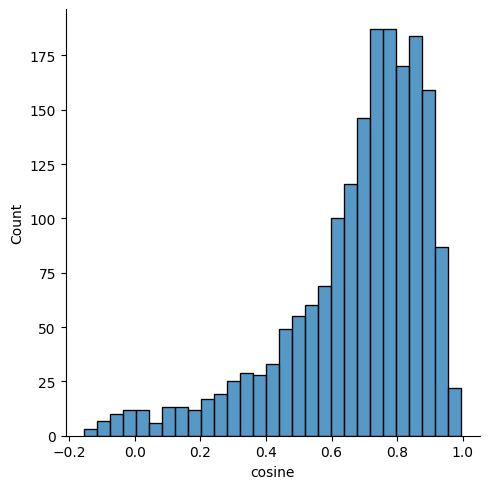

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df_gpt4o['cosine'], label='gpt4o')

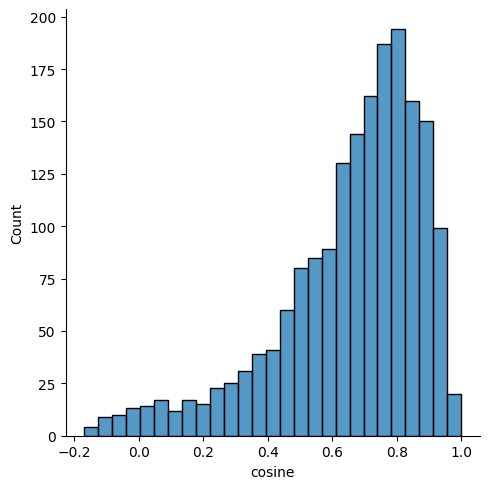

In [45]:
sns.displot(df_gpt35['cosine'], label='gpt35')

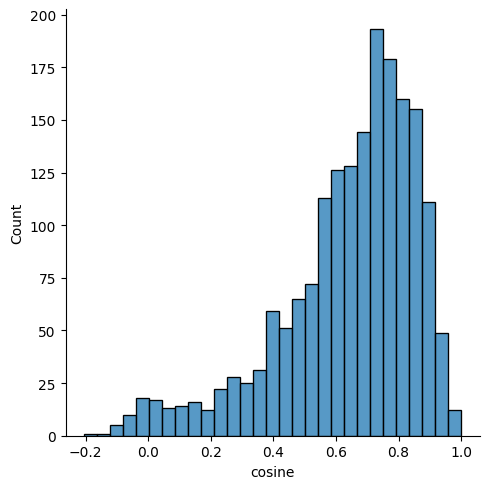

In [46]:
sns.displot(df_llama31['cosine'], label='llama31')

/tmp/ipykernel_7967/3384336615.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='gpt4o')
/tmp/ipykernel_7967/3384336615.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='gpt35')
/tmp/ipykernel_7967/3384336615.py:3: UserWarning: 

`distplo

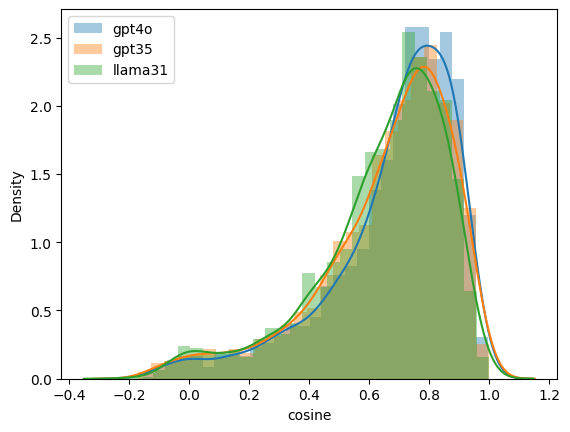

In [51]:

sns.distplot(df_gpt4o['cosine'], label='gpt4o')
sns.distplot(df_gpt35['cosine'], label='gpt35')
sns.distplot(df_llama31['cosine'], label='llama31')

plt.legend()


In [52]:
df_gpt4o_mini = pd.read_csv("../data/results-gpt4o-mini.csv")

In [53]:
results_gpt4o_mini = df_gpt4o_mini.to_dict(orient="records")

In [54]:
gpt4omini_similarity = []

for record in tqdm(results_gpt4o_mini):
    sim = compute_similarity(record)
    gpt4omini_similarity.append(sim)


df_gpt4o_mini['cosine'] = gpt4omini_similarity

  0%|          | 0/1830 [00:00<?, ?it/s]

In [55]:
df_gpt4o_mini['cosine'].describe()

count    1830.000000
mean        0.680332
std         0.215962
min        -0.141910
25%         0.585866
50%         0.733998
75%         0.836750
max         0.982701
Name: cosine, dtype: float64

/tmp/ipykernel_7967/120701701.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4o['cosine'], label='gpt4o')
/tmp/ipykernel_7967/120701701.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt35['cosine'], label='gpt35')
/tmp/ipykernel_7967/120701701.py:3: UserWarning: 

`distplot` 

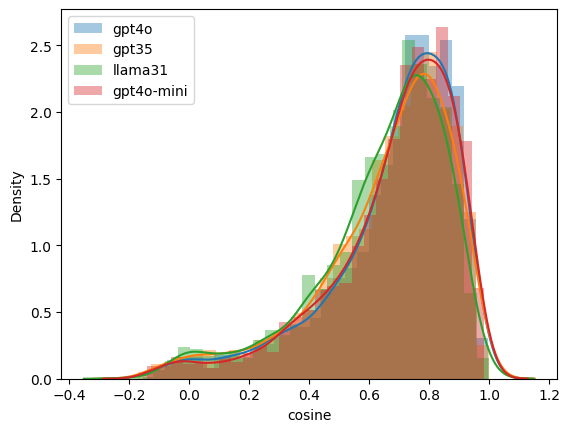

In [56]:
sns.distplot(df_gpt4o['cosine'], label='gpt4o')
sns.distplot(df_gpt35['cosine'], label='gpt35')
sns.distplot(df_llama31['cosine'], label='llama31')
sns.distplot(df_gpt4o_mini['cosine'], label='gpt4o-mini')

plt.legend()


## LLM as a Judge

In [72]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks and without
any extra texts:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()


In [58]:
df_sample = df_gpt4o_mini.sample(n=150, random_state=1)

In [62]:
samples = df_sample.to_dict(orient='records')

In [73]:
record = samples[0]
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using `precision_recall_fscore_support` in Python is as follows:

```python
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_

In [74]:
answer = llm(prompt, model='llama3.1')

In [75]:
answer

'{\n  "Relevance": "RELEVANT",\n  "Explanation": "The generated answer provides the exact syntax and context for using precision_recall_fscore_support in Python, matching the original answer."\n}'

In [76]:
import json

json.loads(answer)

{'Relevance': 'RELEVANT',
 'Explanation': 'The generated answer provides the exact syntax and context for using precision_recall_fscore_support in Python, matching the original answer.'}

In [77]:
answers = []
for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    answer = llm(prompt, "llama3.1")
    answers.append(answer)

  0%|          | 0/150 [00:00<?, ?it/s]

In [86]:
json_evaluations = []
failed = 0

for i, str_eval in enumerate(answers):
    try:
        json_eval = json.loads(str_eval)
        json_evaluations.append(json_eval)
    except json.JSONDecodeError as e:
        json_evaluations.append({"Relevance": "UNKNOWN", "Explanation": ""})
        failed += 1

In [87]:
json_eval

{'Relevance': 'PARTLY_RELEVANT',
 'Explanation': 'The generated answer partially captures the relevant information from the original answer, correctly stating that median_house_value was changed to binary format, but missing the details about the subjective nature of binning continuous variables.'}

In [88]:
failed

3

In [89]:
df_evaluations = pd.DataFrame(json_evaluations)

In [92]:

df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
11,NON_RELEVANT,The generated answer is unrelated to the origi...
27,NON_RELEVANT,The generated answer misinterprets the alterna...
31,NON_RELEVANT,The generated answer does not match the contex...
41,NON_RELEVANT,The generated answer is about setting up a Con...
42,NON_RELEVANT,The generated answer advises replacing problem...
45,NON_RELEVANT,The generated answer states that no commands t...
69,NON_RELEVANT,The generated answer introduces uncertainty by...
87,NON_RELEVANT,The generated answer is not relevant to the or...
93,NON_RELEVANT,The generated answer does not relate to the or...
108,NON_RELEVANT,The generated answer missed one key workaround...


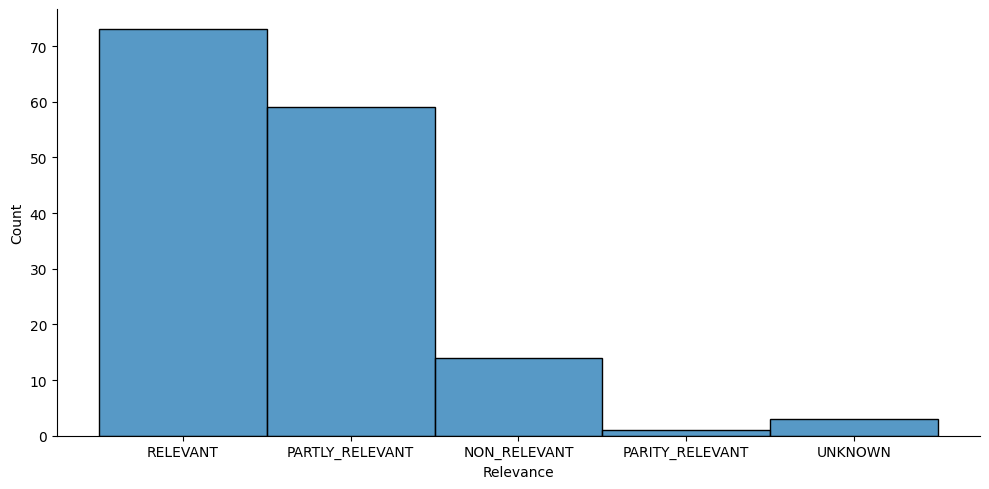

In [96]:
sns.displot(df_evaluations['Relevance'], aspect=2)

In [97]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           73
PARTLY_RELEVANT    59
NON_RELEVANT       14
UNKNOWN             3
PARITY_RELEVANT     1
Name: count, dtype: int64